<a href="https://www.kaggle.com/code/hityangzijian/covid?scriptVersionId=92356110" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

sidr_data = genfromtxt('../input/DINNCOVID/Diseases/COVID/sidr_1000.csv', delimiter=',') #in the form of [t,S,I,D,R]

torch.manual_seed(1234)

In [2]:
%%time

PATH = 'sidr_norm_simple' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        self.N = 59e6 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.save = 2 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        
        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

    #force parameters to be in a range
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) #* 0.1 + 0.2

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) #* 0.01 + 0.05
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) #* 0.01 + 0.03


    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m3, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m4, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
        f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        self.losses = checkpoint['losses']

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

        f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

        loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                torch.mean(torch.square(self.I_hat - I_pred))+
                torch.mean(torch.square(self.D_hat - D_pred))+
                torch.mean(torch.square(self.R_hat - R_pred))+
                torch.mean(torch.square(f1))+
                torch.mean(torch.square(f2))+
                torch.mean(torch.square(f3))+
                torch.mean(torch.square(f4))
                ) 

        #loss.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              #'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

      return S_pred_list, I_pred_list, D_pred_list, R_pred_list

CPU times: user 50 µs, sys: 7 µs, total: 57 µs
Wall time: 63.2 µs


In [3]:
%%time

dinn = DINN(sidr_data[0], sidr_data[1], sidr_data[2], sidr_data[3], 
            sidr_data[4]) #in the form of [t,S,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="exp_range", cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(50000) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(10000) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(10000) #train


starting training...


Epoch  0

Epoch  1000

Epoch  2000

Epoch  3000

Epoch  4000

Epoch  5000

Epoch  6000

Epoch  7000

Epoch  8000

Epoch  9000

Epoch  10000

Epoch  11000

Epoch  12000

Epoch  13000

Epoch  14000

Epoch  15000

Epoch  16000

Epoch  17000

Epoch  18000

Epoch  19000

Epoch  20000

Epoch  21000

Epoch  22000

Epoch  23000

Epoch  24000

Epoch  25000

Epoch  26000

Epoch  27000

Epoch  28000

Epoch  29000

Epoch  30000

Epoch  31000

Epoch  32000

Epoch  33000

Epoch  34000

Epoch  35000

Epoch  36000

Epoch  37000

Epoch  38000

Epoch  39000

Epoch  40000

Epoch  41000

Epoch  42000

Epoch  43000

Epoch  44000

Epoch  45000

Epoch  46000

Epoch  47000

Epoch  48000

Epoch  49000
CPU times: user 14min 54s, sys: 10.4 s, total: 15min 4s
Wall time: 7min 39s


(Text(0, 0.5, 'Loss'),)

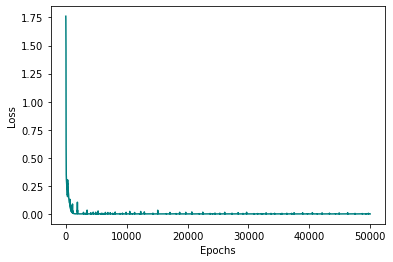

In [4]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss'),

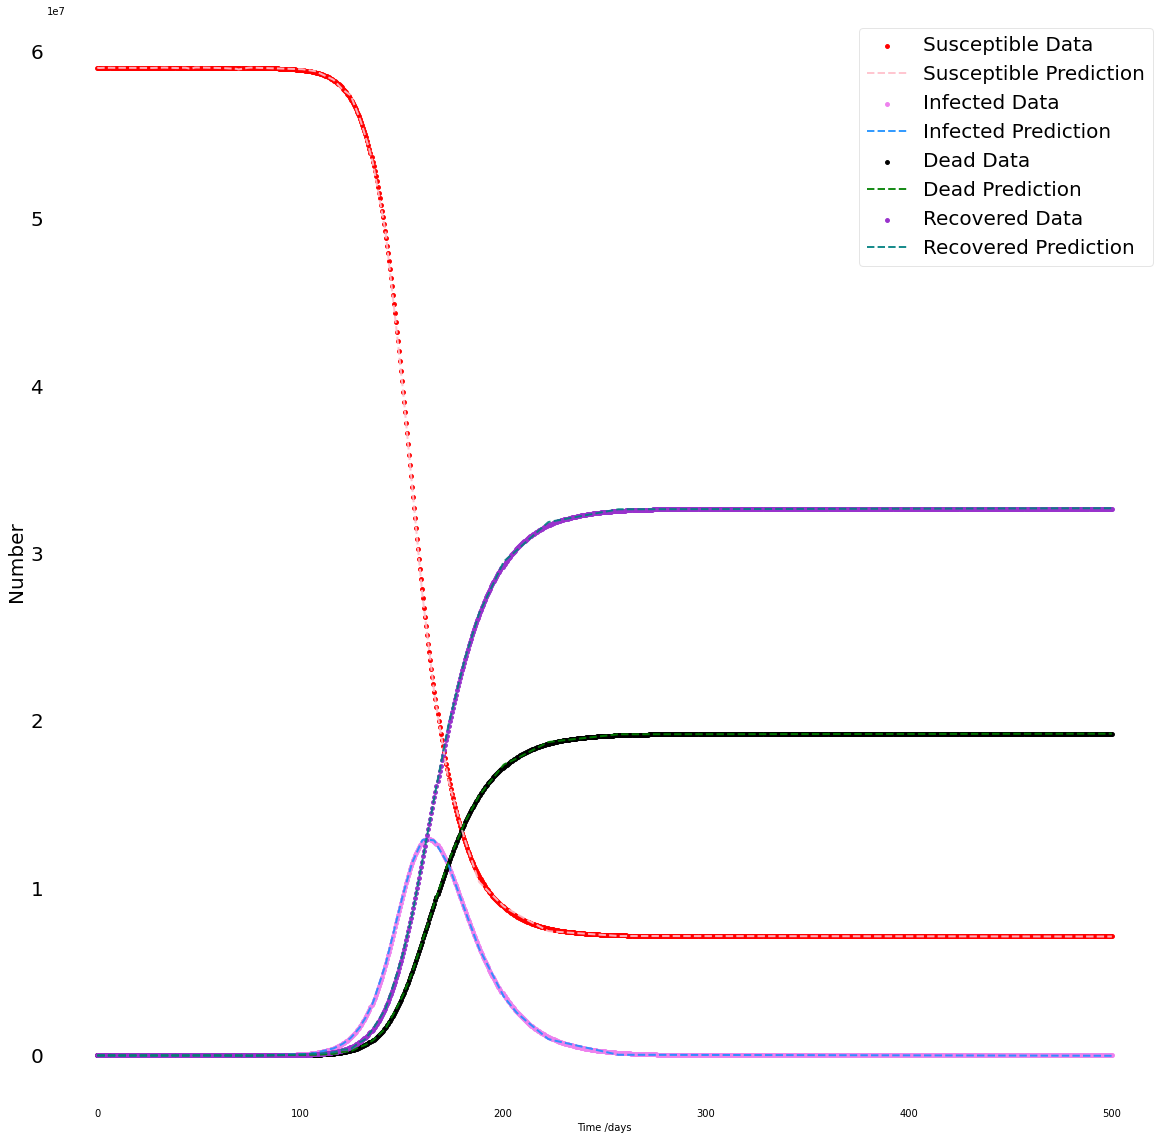

In [5]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')


#ax.scatter(sidr_data[0], sidr_data[1], 'pink', alpha=0.5, lw=2, label='Susceptible', s=15)
ax.scatter(sidr_data[0], sidr_data[1], color = 'red', label='Susceptible Data', s=15)
ax.plot(sidr_data[0], S_pred_list[0].detach().numpy(), 'pink', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

# ax.scatter(sidr_data[0], sidr_data[2], 'violet', alpha=0.5, lw=2, label='Infected', s=15)
ax.scatter(sidr_data[0], sidr_data[2], color = 'violet', label='Infected Data', s=15)
ax.plot(sidr_data[0], I_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

# ax.scatter(sidr_data[0], sidr_data[3], 'darkgreen', alpha=0.5, lw=2, label='Dead', s=15)
ax.scatter(sidr_data[0], sidr_data[3], color = 'black', label='Dead Data', s=15)
ax.plot(sidr_data[0], D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

# ax.scatter(sidr_data[0], sidr_data[4], 'blue', alpha=0.5, lw=2, label='Recovered', s=15)
ax.scatter(sidr_data[0], sidr_data[4], color = 'darkorchid', label='Recovered Data', s=15)
ax.plot(sidr_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 10)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 10)
plt.yticks(size = 20)
# ax.grid(b=True, which='major', c='black', lw=2.2, ls=15-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('covid_missing_I.pdf')
plt.show()